# Tp1 - Ej3

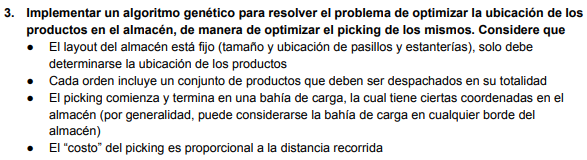


## PREPARATIVOS

### Importaciones

In [167]:
import pygame
import pygame.image
import pygame.surfarray
import random
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output #Para hacer grafica
import statistics

### Variables globales

In [168]:
L_VENTANA = 540

ROJO = (255, 0, 0)
VERDE = (0, 255, 0)
AZUL = (0, 0, 255)
AMARILLO = (255, 255, 0)
BLANCO = (255, 255, 255)
NEGRO = (0, 0, 0)
VIOLETA = (128, 0, 128)
NARANJA = (255, 165 ,0)
GRIS = (128, 128, 128)
TURQUESA = (64, 224, 208)

FILAS = 20
COLUMNAS = 10

#La longitud de cada casilla es la división entera entre la longitud de la ventana y la cantidad de filas (o columnas, ya que es una ventana cuadrada).
ALTO_CASILLA = L_VENTANA // FILAS
ANCHO_CASILLA = L_VENTANA // COLUMNAS

INICIO = None
FINAL = None

CAMINO = [] #acá iré almacenando las casiilas que deben ser recorridas

OBJETIVOS_ALMACEN = [] #los objetivos que seleccionará el usuario

### Clase Nodo

In [169]:
class Nodo:

    def __init__(self, columna_casilla, fila_casilla):
        self.fila_casilla = fila_casilla
        self.columna_casilla = columna_casilla
        self.x = columna_casilla * ANCHO_CASILLA
        self.y = fila_casilla * ALTO_CASILLA
        self.color = BLANCO
        self.padre = None #El padre lo iré actualizando a medida que se vaya formando el camino
        self.numeroAlmacen = 0 #Cada casilla de almacén tenrá un numero
        self.numeroProducto = 0 #Cada cassilla del almacén tendrá un número de producto asociado

        #Estas son las puntuaciones de g (costo de camino) y puntuación f (costo total), que un principio son inf para todos los nodos
        #A medida que los vayamos analizando, los iremos disminuyendo
        self.f = float('inf')
        self.g = float('inf')
    
    def calcular_heuristica(self, nodo_final):
        x1, y1 = self.obtener_posicion()
        x2, y2 = nodo_final.obtener_posicion()
        self.heuristica = abs(x2-x1) + abs(y2-y1)

    def actualizar_f(self):
        self.f = self.g + self.heuristica

    def reiniciar_g_f_padre(self): #Para poder volver a correr el algoritmo en un mismo tablero
        self.g = float('inf')
        self.f = float('inf')
        self.padre = None

    def obtener_posicion(self):
        return self.columna_casilla, self.fila_casilla
    
    def resetear(self):
        self.color = BLANCO

    def hacer_inicio(self):
        self.color = NARANJA
    
    def hacer_objetivo_almacen(self):
        self.color = TURQUESA
    
    def hacer_final(self):
        self.color = AZUL
    
    def hacer_abierta(self):
        self.color = VERDE

    def hacer_cerrada(self):
        self.color = ROJO

    def hacer_obstaculo(self):
        self.color = NEGRO

    def hacer_solucion(self):
        self.color = VIOLETA

    def es_inicio(self):
        return self.color == NARANJA
    
    def es_objetivo_almacen(self):
        return self.color == TURQUESA
    
    def es_final(self):
        return self.color == AZUL
    
    def es_cerrada(self):
        return self.color == ROJO

    def es_abierta(self):
        return self.color == VERDE

    def es_obstaculo(self):
        return self.color == NEGRO
    
    def es_espacio_almacen(self):
        return self.numeroAlmacen > 0

    def pintar_casilla(self):
        global VENTANA
        pygame.draw.rect(VENTANA,self.color,(self.x, self.y, ANCHO_CASILLA, ALTO_CASILLA))

    def actualizar_vecinos(self,matriz):
        
        self.vecinos = []

        x = self.columna_casilla
        y = self.fila_casilla

        #NOTAR QUE PRIMERO MIRO A LOS COSTADOS. A LOS ALMACENES SIEMPRE PUEDO ACCEDER POR ALGUNO DE LOS DOS COSTADOS. POR LO TANTO TOMANDO EL PRIMER ELEMENTO DEL ATRIBUTO VECINOS, PUEDO ACCEDER A LA CASILLA INICIAL

        #Notar que al mirar para la izquierda y la derecha, un espacio de almacén no puede agregar a otro espacio de almacén como vecino. Esto es importante para cuando hay dos objetivos_almacén pegados. Fuerza a que el robot tenga que dar toda la vuelta a la estantería.

        #Miro para izquierda
        if x > 0 and not matriz[x-1][y].es_obstaculo():
            if self.es_espacio_almacen() and matriz[x-1][y].es_espacio_almacen():
                pass
            else:
                self.vecinos.append(matriz[x-1][y])
        
        #Miro para derecha
        if x < COLUMNAS-1 and not matriz[x+1][y].es_obstaculo():
            if self.es_espacio_almacen() and matriz[x+1][y].es_espacio_almacen():
                pass
            else:
                self.vecinos.append(matriz[x+1][y])        

        #Miro para arriba
        if y > 0 and not matriz[x][y-1].es_obstaculo() and not matriz[x][y-1].es_objetivo_almacen():
            self.vecinos.append(matriz[x][y-1])

        #Miro para abajo
        if y < FILAS-1 and not matriz[x][y+1].es_obstaculo() and not matriz[x][y+1].es_objetivo_almacen():
            self.vecinos.append(matriz[x][y+1])

### Funciones de dibujo

In [170]:
def dibujarLineas():
    #Dibujo líneas verticales
    for i in range(COLUMNAS):
        pygame.draw.line(VENTANA,GRIS,(i*ANCHO_CASILLA,0),(i*ANCHO_CASILLA,L_VENTANA))
        #Dibujo líneas horizontales
        for j in range(FILAS):
            pygame.draw.line(VENTANA,GRIS,(0,j*ALTO_CASILLA),(L_VENTANA,j*ALTO_CASILLA))


def dibujarTexto(texto, fuente, color, x, y):
    img = fuente.render(texto, True, color)
    VENTANA.blit(img, (x,y))
    
    
def dibujarNumeros(matriz):    
    for fila in matriz:
        for nodo in fila:
            if nodo.numeroProducto>0:
                dibujarTexto(str(nodo.numeroProducto), fuente_texto, BLANCO, nodo.x , nodo.y)

#Esta función es la encargada de dibujar todos los elementos de la ventana por cada frame
def dibujar(matriz):
    
    #Primero pinto de blanco el fondo
    global VENTANA
    VENTANA.fill(BLANCO)

    #Pinto las casillas
    for fila in matriz:
        for nodo in fila:
            nodo.pintar_casilla()
    
    #Dibujo las líneas. Si lo hago antes de pintar las casillas, quedarán tapadas
    dibujarLineas()

    #dibujo los números al final de todo
    dibujarNumeros(matriz)

    #escribo "inicio" y "final" si ya han sido seleccionadas las casillas
    global fuente_texto
    if INICIO: dibujarTexto("Inicio", fuente_texto, NEGRO, INICIO.x, INICIO.y)
    if FINAL: dibujarTexto("Final", fuente_texto, BLANCO, FINAL.x, FINAL.y)

    #Con esto voy actualizando la pantalla
    pygame.display.update()


#Esta función será la encargada de limpiar el tablero por completo
def limpiar_tablero(matriz):

    for fila in matriz:
        for nodo in fila:
            if nodo.es_abierta() or nodo.es_cerrada():
                nodo.resetear()
    
    global CAMINO
    CAMINO = []

### Interfaz Gráfica

In [171]:
def interfazGrafica(matriz):
    pygame.init()
    global VENTANA

    VENTANA = pygame.display.set_mode((L_VENTANA, L_VENTANA))   #En este objeto ventana es donde hago todo lo que sea gráfico
    pygame.display.set_caption('Mapa del Almacen') #nombre que aparece arriba de la ventana

    #Fuente para escribir textos. Se usará para colocar los números de las casillas en el apartado gráfico
    global fuente_texto
    fuente_texto = pygame.font.SysFont("Arial", 15, bold = True)
    
    global INICIO
    global FINAL
    global CAMINO
    global OBJETIVOS_ALMACEN

    run = True
    while(run):
        dibujar(matriz)
        #Capturo los eventos que ocurran durante la ejecucion
        for event in pygame.event.get():
            
            #Si presiono la cruz para finalizar el programa
            if event.type == pygame.QUIT:
                run = False
            
            #Si presiono click izquierdo
            if pygame.mouse.get_pressed()[0]:
                pos = pygame.mouse.get_pos()
                columna, fila = obtenerPosClick(pos)
                nodo = matriz[columna][fila]

                if not INICIO and not nodo.es_espacio_almacen():
                    nodo.hacer_inicio()
                    INICIO = nodo

                elif not FINAL and not nodo.es_espacio_almacen() and nodo != INICIO:
                    nodo.hacer_final()
                    FINAL = nodo

                elif nodo.es_espacio_almacen() and not nodo.es_objetivo_almacen(): 
                    nodo.hacer_objetivo_almacen()
                    OBJETIVOS_ALMACEN.append(nodo)
                

            #Si presiono click derecho
            if pygame.mouse.get_pressed()[2]:
                pos = pygame.mouse.get_pos()
                columna, fila = obtenerPosClick(pos)
                nodo = matriz[columna][fila]
                
                if nodo.es_inicio():
                    nodo.resetear()
                    INICIO = None

                if nodo.es_final():
                    nodo.resetear()
                    FINAL = None

                if nodo.es_objetivo_almacen():
                    nodo.hacer_obstaculo()
                    OBJETIVOS_ALMACEN.remove(nodo)

            #Si detecta una presión de tecla
            if event.type == pygame.KEYDOWN:

                #Si apreto r para resetear el tablero
                if event.key == pygame.K_r:
                    for fila in matriz:
                        for nodo in fila:
                            nodo.resetear()
                    asignarNumero(matriz)
                    INICIO = None
                    FINAL = None
                    CAMINO = []
                    OBJETIVOS_ALMACEN = []
                    print("||||||||||||||||||||||||||||||||||||||||||||||||||")

                #Si apreto barra espaciadora para empezar algoritmo
                elif event.key == pygame.K_SPACE and INICIO and OBJETIVOS_ALMACEN and FINAL:
                    
                    run = False
                    

        
    pygame.display.quit()

### Funciones lógicas

In [172]:
def crearMatrizNodos():
    matriz = []
    for i in range(COLUMNAS):
        matriz.append([])
        for j in range(FILAS):
            nodo = Nodo(i,j)
            matriz[i].append(nodo)
    return matriz

def obtenerPosClick(pos): #convierte la posición x-y del mouse en columna-fila
    x_click, y_click = pos
    columna = x_click // ANCHO_CASILLA
    fila = y_click // ALTO_CASILLA
    return columna,fila

def guardarCamino(matriz, nodo_final):
    flag = True
    nodo = nodo_final
    caminoCorto = [] #Lista auxiliar donde se guardan nodos pero desde el final hasta el iniciao (como recorriendo en camino inverso)
    while flag:
        #Como el robot no entra al espacio de almacén, su última posición debe ser una casilla antes.
        if nodo.padre and nodo.padre!=INICIO:
            nodo = nodo.padre
            caminoCorto.append(nodo)
        
        #Una vez recorro toda la herencia
        else:
            for nodo in reversed(caminoCorto): #Acá guardo la lista pero esta vez bien ordenada desde el inicio al final
                CAMINO.append(nodo)
            caminoCorto = []
            flag = False

    return False


def dibujarCamino(matriz):

    for nodo in CAMINO:
        nodo.hacer_solucion()
        dibujar(matriz)


    
    

### Asignar número productos

Tengo que asignar a las casillas del almacén un número a cada una. El resto quedarán en cero. Las casillas con número serán posibles elecciones de casilla objetivo. Debe quedar algo así:

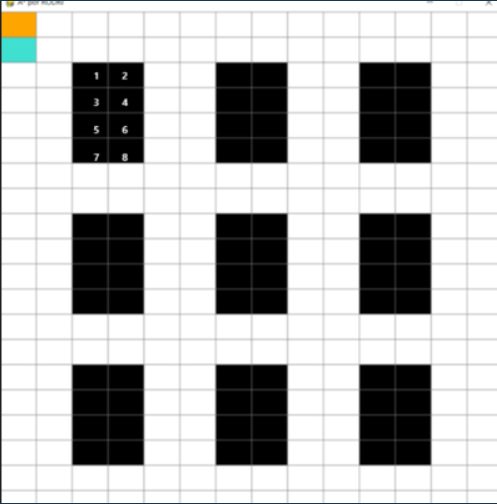

Correción: se necesita tener más de 100 espacios en al almacen, por lo que se agrega una fila extra de almacenamiento

Corrección 2: se redujo significativamente la cantidad de espacios de almacén para disminuir el tiempo de cómputo sobre todo para el ejercicio 3 de algoritmo genético.

Asigno números

In [173]:
def asignarNumero(matriz):
    
    #De forma muy rústica le pongo números a cada elemento del almácen.

    #ELEMENTOS DE LA IZQUIERDA
    conteo = 1
    conjuntoDe8(matriz, 2, 2, conteo) #asigno del 1 al 8
    conteo += 8
    conjuntoDe8(matriz, 6, 2, conteo) #asigno del 9 al 16
    #conteo += 8
    #conjuntoDe8(matriz, 10, 2, conteo) #asigno del 17 al 24
    #conteo += 8
    #conjuntoDe8(matriz, 14, 2, conteo)

    #ELEMENTOS DEL CENTRO
    conteo += 8
    conjuntoDe8(matriz, 2, 8, conteo) #asigno del 25 al 32
    conteo += 8
    conjuntoDe8(matriz, 6, 8, conteo) #asigno del 33 al 40
    #conteo += 8
    #conjuntoDe8(matriz, 10, 8, conteo) #asigno del 41 al 48
    #conteo += 8
    #conjuntoDe8(matriz, 14, 8, conteo)

    #ELEMENTOS DE LA DERECHA
    conteo += 8
    conjuntoDe8(matriz, 2, 14, conteo) #asigno del 49 al 56
    conteo += 8
    conjuntoDe8(matriz, 6, 14, conteo) #asigno del 54 al 64
    conteo += 8
    #conjuntoDe8(matriz, 10, 14, conteo) #asigno del 65 al 72
    #conteo += 8
    #conjuntoDe8(matriz, 14, 14, conteo)

    #AGREGO UNA MÁS A LA DERECHA PARA TENER MÁS DE 100 POSICIONES
    #conteo += 8
    #conjuntoDe8(matriz, 2, 20, conteo) 
    #conteo += 8
    #conjuntoDe8(matriz, 6, 20, conteo)
    #conteo += 8
    #conjuntoDe8(matriz, 10, 20, conteo) 
    #conteo += 8
    #conjuntoDe8(matriz, 14, 20, conteo)

    #Devuelvo una lista con los nodos pertenecientes al almacen
    nodos_almacen = []
    for filas in matriz:
        for nodo in filas:
            if nodo.es_espacio_almacen():
                nodos_almacen.append(nodo)

    return nodos_almacen
    


def conjuntoDe8(matriz, xi, yi, conteo): #xi e yi determinan la posición del nodo más arriba a la izquierda del conjunto de 8
    for j in range(yi,yi+4):
        for i in range(xi, xi+2):
            matriz[i][j].numeroAlmacen = conteo
            matriz[i][j].numeroProducto = conteo #inicialmente cada producto compartirá el mismo número de almacen, esto cambiará en el punto 3 de algoritmo genético
            matriz[i][j].hacer_obstaculo()
            conteo += 1



## ALGORITMO A*

### A* básico

Se va desde un nodo hasta otro

In [174]:
#F(n) = G(n)+H(n) el valor para cierto nodo es la suma entre el costo y le heurística.
def algoritmoAestrella(matriz, nodo_inicial, nodo_objetivo):

    global CAMINO

    #Conociendo el nodo final, calculo la heurística para cada nodo de la matriz
    for fila in matriz:
        for nodo in fila:
            nodo.calcular_heuristica(nodo_objetivo)

            #De paso reinicio el valor g y f de cada nodo (para poder volver a correr el algorimo en un mismo tablero)
            nodo.reiniciar_g_f_padre()
    
    CAMINO = [] #Reinicio para poder aplicar nuevamente el algoritmo

    #Declaro los valores de costo de camino y puntaución f para el nodo inicial
    nodo_inicial.g = 0
    nodo_inicial.actualizar_f()

    #Agrego inicio a la cola de análisis
    cola = [nodo_inicial]

    flag = True
    while flag:

        #Selecciono el nodo con menor f en la cola
        f_min = float('inf')

        if len(cola)==0: #Esto es para evitar que falle el programa cuando no hay nada en la lista cola
            print('No hay solucion')
            return False

        for nodo in cola:
            if nodo.f < f_min:
                f_min = nodo.f
                seleccion = nodo

        cola.remove(seleccion)  #Elimino de la cola al nodo que se analizará a continuación
    
        #A cada vecino le actualizaré el valor g SOLO SI EL VALOR g NUEVO ES MENOS AL QUE YA TENÍAN 
        #De paso si, el g cambia, le tengo que cambiar el padre al vecino. Esto lo hago para que una casilla, que ya fue analizada, pueda tener un nuevo camino pero más corto.
        for vecino in seleccion.vecinos:

            if vecino == nodo_objetivo:
                vecino.padre = seleccion
                
                #Meto las casillas que conforman el camino en una lista
                guardarCamino(matriz, vecino) 
                
                #Reinicio el sistema de padres para poder luego volver a aplicar A*
                for fila in matriz:
                    for nodo in fila:
                        nodo.padre = None  
                
                #Vuelvo los nodos importantes a su estado inicial
                #nodo_objetivo.hacer_objetivo_almacen()
                INICIO.hacer_inicio()
                FINAL.hacer_final()

                #interfazGrafica(matriz)

                return False
                

            elif seleccion.g+1 < vecino.g:
                vecino.g = seleccion.g+1
                vecino.padre = seleccion
        
            #Actualizo los valores f de cada vecino
            f_viejo = vecino.f #guardo el valor f antes de cambiarlo para analizarlo más tarde
            vecino.actualizar_f()

            #Pongo al vecino en cola de análisis sólo si su nuevo valor f es menor al que tenía, y si no es un obstaculo
            if vecino.f < f_viejo and not vecino.es_obstaculo() and not vecino.es_objetivo_almacen():
                #Lo pinto de verde para indicar que está en cola de análisis
                vecino.hacer_abierta()
                cola.append(vecino)
        
        
        #Finalmente, pinto el nodo analizado de rojo para indicar que ya ha sido analizado
        if not seleccion.es_inicio():    #Para que no se pinte de rojo la casilla inicial
            seleccion.hacer_cerrada()
        

### A* en cadena

Se llama varias veces A* para recoger a todos los productos en una lista y llevarlos hasta el final

In [175]:
def A_estrella_lista(matriz, lista):

    global INICIO
    global FINAL
    global CAMINO
    
    camino_total = []

    #Primero voy de INICIO hasta el primer punto de la lista
    algoritmoAestrella(matriz, INICIO, lista[0])
    camino_total.extend(CAMINO)

    #Ahora voy desde prod1 hasta prod2, de prod2 a prod3, ...
    for i in range(len(lista)-1): #Recorre todo menos el último

        algoritmoAestrella(matriz, lista[i].vecinos[0], lista[i+1])
        camino_total.extend(CAMINO)

    #Finalmente voy del último elemento de la lista hasta FINAL
    algoritmoAestrella(matriz, lista[-1].vecinos[0], FINAL)
    camino_total.extend(CAMINO)
    
    #devuelvo la lista final de casillas que conforman al camino
    return camino_total

### Dataframe distancias

Para ahorrar tiempo de cálculo. Previamente se guardó en un dataframe el costo de camino de ir desde un espacio de almacén hasta otro. Esto es realmente útil para ahorrar realizar el algoritmo A* para el algortirmo de recocido simulado.

A acontinuación se procede a realizar la importanción del dataframe

In [176]:
dfDistancias = pd.read_csv('dfDistancias.csv', index_col='Unnamed: 0')
dfDistancias.set_axis(dfDistancias.index, axis=1, inplace=True)

dfDistancias

,1,3,5,7,17,19,21,23,33,35,...,14,16,26,28,30,32,42,44,46,48
1,0,1,2,3,6,7,8,9,12,13,...,11,12,13,14,15,16,19,20,21,22
3,1,0,1,2,5,6,7,8,11,12,...,12,11,12,13,14,15,18,19,20,21
5,2,1,0,1,4,5,6,7,10,11,...,11,10,11,12,13,14,17,18,19,20
7,3,2,1,0,3,4,5,6,9,10,...,10,9,10,11,12,13,16,17,18,19
17,6,5,4,3,0,1,2,3,6,7,...,11,10,9,10,11,12,13,14,15,16
19,7,6,5,4,1,0,1,2,5,6,...,12,11,10,11,12,11,12,13,14,15
21,8,7,6,5,2,1,0,1,4,5,...,13,12,11,12,11,10,11,12,13,14
23,9,8,7,6,3,2,1,0,3,4,...,14,13,12,11,10,9,10,11,12,13
33,12,11,10,9,6,5,4,3,0,1,...,17,16,13,12,11,10,9,10,11,12
35,13,12,11,10,7,6,5,4,1,0,...,18,17,14,13,12,11,10,11,12,11


Si por ejemplo queremos conocer el costo de camino de ir desde el producto 2 al 10:

In [177]:
dfDistancias[2][10]

6

## ALGORITMO RECOCIDO SIMULADO

### Funciones recocido simulado

In [178]:
#Las posibles soluciones se consiguen cambiando el orden de dos elementos consecutivos en el que serán buscados los productos en el vector de objetivos_almacen
def permutar_elementos(lista_original):
    
    lista = lista_original[:]

    if len(lista)==1:
        pass
    else:
        indice_aleatorio = random.randint(0,len(lista)-2) #No puede ser elegido el último elemento ya que permuto el que señala el índice con el siguiente

        temporal = lista[indice_aleatorio]
        lista[indice_aleatorio] = lista[indice_aleatorio+1]
        lista[indice_aleatorio+1] = temporal
    
    return lista


def alfa(T):    #Disminuye la temperatura un 20%
    return T*0.9


def E(lista):   #Devuelve la energía de una lista
    #Se obtiene al sumar los caminos del dataframe
    suma = 0

    #Sumo de INICIO al primer producto
    suma += dfDistancias['INICIO'][lista[0].numeroAlmacen]

    #Sumo del primero al segundo, del segundo al tercero, ...
    for i in range(len(lista)-1): #Recorre todo menos el último elemento
        suma += dfDistancias[lista[i].numeroAlmacen][lista[i+1].numeroAlmacen]

    #Sumo del último a FINAL
    suma += dfDistancias['FINAL'][lista[-1].numeroAlmacen]

    return suma


### Algoritmo Recocido simulado

In [179]:
def recocidoSimulado(objetivos_almacen, T_inicial, Tf, L=0):

    mejor_solucion = [] #acá guardaré la mejor solucion
    E_mejor_solucion = float("inf") #Inicializo en la peor situación

    global CAMINO
    CAMINO = []

    if L==0:
        #L es variable. Si hay 5 productos, L será 20 y si hay 10, L será 300 esto se sacó a prueba y error
        L = 56*len(objetivos_almacen)-260

    T = T_inicial   #Establezco temperatura inicial

    #Creo un vector solución arbitrario. En este caso es el vector objetivos_almacen en el orden en el que fueron elegidos
    solucion = objetivos_almacen
    E_solucion = E(solucion)

    
    '''#PARA DEBUGEO DEL ALGORITMO
    lista1 = []
    for sol in solucion:
        lista1.append(sol.numeroProducto)
    print('Solucion inicial: '+ str(lista1) +'\nDistancia: '+str(E(solucion))+'\n\n')
    ''' 
    while T>Tf:
        
        #Para cada temperatura itero L veces, que puede variar o no con la temperatura. En este caso es cte
        for i in range(L):

            #Genero una solución candidata al azar
            solucion_candidata = permutar_elementos(solucion)
            
            '''#PARA DEBUGEO DEL ALGORITMO
            lista2 = []
            for sol in solucion_candidata:
                lista2.append(sol.numeroProducto)
            print('Solucion propuesta: '+ str(lista2) +'\nDistancia: '+str(E(solucion_candidata)))
            '''
            E_sol_candidata = E(solucion_candidata)

            deltaE = E_sol_candidata - E_solucion #Como busco disminuir, lo ideal es que sea un número negativo

            #Acá cómparo con la mejor solución obtenida de todos los tiempos.
            if E_sol_candidata<E_mejor_solucion:
                E_mejor_solucion = E_sol_candidata
                mejor_solucion = solucion_candidata

            
            #Si deltaE es negativo, actualizo la solución, si es positivo, dejo a la suerte que elija si actualiza o no
            Boltzmann = math.e ** (-deltaE/T)

            if random.random() < Boltzmann or deltaE<0:
                solucion = solucion_candidata
                E_solucion = E_sol_candidata
            
        #Actualizo T
        T = alfa(T)


    #Terminado el algoritmo, devuelvo la solución
    return mejor_solucion

def recocidoSimulado(objetivos_almacen, T_inicial, Tf, L=0):

    global CAMINO
    CAMINO = []

    if L==0:
        #L es variable. Si hay 5 productos, L será 200 y si hay 10, L será 1000
        L = 160*len(objetivos_almacen)-600

    T = T_inicial   #Establezco temperatura inicial

    #Creo un vector solución arbitrario. En este caso es el vector objetivos_almacen en el orden en el que fueron elegidos
    solucion = objetivos_almacen

    
    '''#PARA DEBUGEO DEL ALGORITMO
    lista1 = []
    for sol in solucion:
        lista1.append(sol.numeroProducto)
    print('Solucion inicial: '+ str(lista1) +'\nDistancia: '+str(E(solucion))+'\n\n')
    ''' 
    while T>Tf:
        
        #Para cada temperatura itero L veces, que puede variar o no con la temperatura. En este caso es cte
        for i in range(int(L)):

            #Genero una solución candidata al azar
            solucion_candidata = permutar_elementos(solucion)
            
            '''#PARA DEBUGEO DEL ALGORITMO
            lista2 = []
            for sol in solucion_candidata:
                lista2.append(sol.numeroProducto)
            print('Solucion propuesta: '+ str(lista2) +'\nDistancia: '+str(E(solucion_candidata)))
            '''

            deltaE = E(solucion_candidata) - E(solucion) #Como busco disminuir, lo ideal es que sea un número negativo
            
            #Si deltaE es negativo, actualizo la solución, si es positivo, dejo a la suerte que elija si actualiza o no
            Boltzmann = math.e ** (-deltaE/T)

            if random.random() < Boltzmann or deltaE<0:
                solucion = solucion_candidata
            
        #Actualizo T
        T = alfa(T)


    #Terminado el algoritmo, devuelvo la solución
    return solucion

### Recocido simulado iterativo

In [180]:
def recocidoSimuladoIterativo(matriz, n, T_inicial, L, Tf):
    
    tiempo_inicio = time.time()

    contador_repetidos = {}
    resultados = {}
    for i in range(n):
        solucion = recocidoSimulado(OBJETIVOS_ALMACEN, T_inicial, L, Tf)
        
        puntuacion=E(solucion)
        resultados[puntuacion] = solucion
        
        #Para llevar el conteo de cuantas veces obtengo cada solución
        try: contador_repetidos[puntuacion] += 1
        except: contador_repetidos[puntuacion] = 1

    tiempo_final = time.time()
    tiempo_dif = tiempo_final - tiempo_inicio
    print(f"Tiempo de ejecución: {tiempo_dif:.2f} s")

    #Muestro todos los posibles resultados que se han obtenido con el recocido simulado y la cantidad de veces que se ha repetido cada uno
    print("Costos de camino obtenido y cantidad de veces que se repite cada uno: ")
    print(contador_repetidos)

    print("\nEl menor valor es " + str(min(contador_repetidos.keys())) +" a sido elegido un " + str(contador_repetidos[min(contador_repetidos.keys())]*100/n) + "% de las veces")

    solucion = resultados[min(resultados.keys())]

    return solucion

### Recocido simulado con recalentamiento

> Se opta por no usarlo ya que no genera una mejora en los resultados

Se crea una solución inicial partiendo del orden en el que se eligen los productos.
Esa solución se mete en el recocido simulado y se obtiene una nueva solución que será la que se meta nuevamente en el recocido simulado.

In [181]:
def recocidoSimuladoRecalentamiento(matriz, n, T_inicial, L, Tf):

    tiempo_inicio = time.time()

    solucion = OBJETIVOS_ALMACEN 
    contador_repetidos = {}
    resultados = {}
    for i in range(n):
        solucion = recocidoSimulado(matriz, solucion, T_inicial, L, Tf)
        
        T_inicial-=T_inicial/n
        puntuacion=E(solucion)
        resultados[puntuacion] = solucion
        
        #Para llevar el conteo de cuantas veces obtengo cada solución
        try: contador_repetidos[puntuacion] += 1
        except: contador_repetidos[puntuacion] = 1

    tiempo_final = time.time()
    tiempo_dif = tiempo_final - tiempo_inicio
    print(f"Tiempo de ejecución: {tiempo_dif:.2f} s")

    #Muestro todos los posibles resultados que se han obtenido con el recocido simulado y la cantidad de veces que se ha repetido cada uno
    print("Costos de camino obtenido y cantidad de veces que se repite cada uno: ")
    print(contador_repetidos)

    print("\nEl menor valor es " + str(min(contador_repetidos.keys())) +" a sido elegido un " + str(contador_repetidos[min(contador_repetidos.keys())]*100/n) + "% de las veces")

    solucion = resultados[min(resultados.keys())]

    return solucion

## LISTAS ORDENES

Se tendrán 20 listas cada una con entre 5 y 10 productos que deberán ser recogidos.

Actualmente tenemos 48 productos en el almacén.

Las listas se generarán de forma aleatoria

In [182]:
def generar_listas(n, L_min, L_max, N_max):
    # Generar n listas
    listas_ordenes = []
    for i in range(n):
        x = random.randint(L_min, L_max) # Número de elementos en la lista entre tanto y tanto
        lista = random.sample(range(1, N_max), x) # Generar lista sin repetir valores entre 1 y N_max
        listas_ordenes.append(lista)
        print(lista) # Imprimir lista generada
    
    return listas_ordenes

## ALGORITMO GENÉTICO

### Generación de individuos

Cada individuo tendrá un orden diferente de cómo estarán ordenados los productos en el almacén

In [183]:
def generar_individuos(n, N_max):
    # Generar n individuos
    # N_max es la cantidad de espacios de almacén que hay
    individuos = []
    for i in range(n):
        lista = random.sample(range(1, N_max+1), N_max) # Generar lista con números del 1 hasta N_max sin repetir numeros
        individuos.append(lista)
        #print(lista) # Imprimir lista generada
    
    return individuos

### Puntuaciones

Se le da a cada individuo una puntuación usando A* y Temple Simulado

In [184]:
def calcular_puntuacion(nodos_almacen, individuo, lista_ordenes, parametros_temple):

    #Primero cambio el orden del almacen al dado por el individuo.
    i = 0
    for nodo in nodos_almacen:
        nodo.numeroProducto=individuo[i]
        i+=1
    
    #Es importante aclarar que lo que cambió fue el numero de producto. Pero el numero de almacén sigue cte. Cuando calculamos las distancias con A* se usa el número de almacén. Sin embargo, los productos a recoger esta dado por el numero de producto

    puntuacion_total = 0

    for orden in lista_ordenes:
        puntuacion_total += puntuacion_una_orden(nodos_almacen,
                                                 orden,
                                                 parametros_temple)

    puntuacion_promedio = puntuacion_total/len(lista_ordenes)    
    
    return puntuacion_promedio
        


def puntuacion_una_orden(nodos_almacen, orden, parametros_temple):
    
    #t_inicial = time.time()
    #Establezco los productos de la orden como objetivos de almacen
    objetivos_almacen = []
    for nodo in nodos_almacen:
        if nodo.numeroProducto in orden:
            objetivos_almacen.append(nodo)

    #Ya podemos hacer el cálculo de su coste con recocido simulado
    solucion = recocidoSimulado(objetivos_almacen,
                                T_inicial=parametros_temple[0],
                                Tf=parametros_temple[1],
                                L=parametros_temple[2])
    
    #t_final = time.time()
    #print(f"Un recocido simulado demora: {t_final-t_inicial:.2f}" )
    
    return E(solucion)


def puntuacion_poblacion(nodos_almacen, individuos, listas_ordenes, parametros_temple):
    puntuaciones = []
    i=0
    for individuo in individuos:
        ti = time.time()
        puntuaciones.append(calcular_puntuacion(nodos_almacen,
                                            individuo,
                                            listas_ordenes,
                                            parametros_temple))
        tf = time.time()
        print(f"Individuo {i} analizado en: {tf-ti:.2f} s")
        i+=1

    return puntuaciones

### Ruleta, cruce y mutación

In [185]:
def ruleta_con_peso(individuos, puntuaciones):
     
    #Como se busca que los que tengan un puntaje más bajo sean los más probables de ser seleccionados, primero resto al puntaje máximo cada puntaje individual. Ahora los que antes tenían menor puntaje, tendrán el mayor.
    puntuaciones = [max(puntuaciones)-x for x in puntuaciones]
    #Normalizo las puntuaciones de forma tal que la suma de todas sea 1
    punt_norm = [x/sum(puntuaciones) for x in puntuaciones]

    #print(puntuaciones)
    #print(punt_norm)

    #Estos serán los nodos seleccionados
    nodo1 = None
    nodo2 = None
    
    #Valor actual irá incrementando desde 0 hasta máximo 1
    valor_actual = 0
    #Valor que determina cuál será el elemento elegido
    azar = random.random()

    i=0
    while i < len(individuos):
        
        valor_actual += punt_norm[i]
        #print(f"Valor actual {valor_actual:.2f}")
        
        if valor_actual > azar and not nodo1:
            #print("Seleccionado")
            nodo1 = individuos[i]
            valor_actual = 0
            i=0
            azar = random.random()
            #print(f"Azar2: {azar:.2f}")
            continue
        elif valor_actual > azar and individuos[i] != nodo1:
            nodo2 = individuos[i]
            #print("Seleccionado2")
            return nodo1, nodo2
        elif i==len(individuos)-1:
            i=0
            continue
        i+=1

def cruzar_padres(padre1, padre2):
    #la técnica usada se llama ordered_crossover. Consiste en establecer unos índices que serviran como punto de corte 1 y un punto de corte 2. El hijo 1, entre esos puntos, mantendra los mismo elementos del padre 1 y rellenará el resto con los elementos del padre 2, verificando que los elementos del padre 2 aun no hayan sido colocados en el hijo 1. De forma similar se hará para el segundo hijo, pero la carte cortada será del padre 2 y se rellenará con los elementos del padre 1.

    n = len(padre1)
    # Escogemos dos puntos aleatorios de corte
    corte1, corte2 = sorted(random.sample(range(1, n), 2)) #con sorted me aseguro que 1 va a ser siempre menor que 2

    # Creamos una lista de hijos vacía
    hijo1 = [None] * n
    hijo2 = [None] * n

    # Copiamos la subsección de genes del primer padre
    hijo1[corte1:corte2] = padre1[corte1:corte2]
    hijo2[corte1:corte2] = padre2[corte1:corte2]

    # Recorremos los genes del segundo padre en el orden en que aparecen
    # y los vamos añadiendo al hijo 1 si no están ya presentes
    for i in range(n):
        if padre2[i] not in hijo1:
            for j in range(n):
                if hijo1[j] is None:
                    hijo1[j] = padre2[i]
                    break

    # Hacemos lo mismo con el hijo 2
    for i in range(n):
        if padre1[i] not in hijo2:
            for j in range(n):
                if hijo2[j] is None:
                    hijo2[j] = padre1[i]
                    break

    return hijo1, hijo2

def mutacion(vector):
    #Consiste en intercambiar las posiciones de dos elementos aleatorios del vector
    n = len(vector)
    i, j = random.sample(range(n), 2)
    vector[i], vector[j] = vector[j], vector[i]
    return vector


### Método de convergencia

In [186]:
#Un método es calcular la desviación estandar de las últimas mejores puntuaciones para ver si es menor a un valor umbral

def desviacion_estandar_n(lista, n):
    # Tomamos los últimos n elementos de la lista y obtenemos el mínimo de cada uno
    minimos = [min(sublista) for sublista in lista[-n:]]
    # Calculamos la desviación estándar de los mínimos
    desv_estandar = statistics.stdev(minimos)
    return desv_estandar

### Funciones para gráfica

In [187]:
def plot_minimos(vectores, fig, ax):
    minimos = [min(vector) for vector in vectores]
    ax.plot(range(len(minimos)), minimos)
    ticks = range(len(minimos))
    labels = [f"{i+1}" for i in range(len(minimos))]
    ax.set(xticks=ticks, xticklabels=labels, ylabel="Valor mínimo")
    #ax.xticks(range(len(minimos)), [f"Vector {i+1}" for i in range(len(minimos))])
    #ax.ylabel("Valor mínimo")
    fig.canvas.draw()  # Actualizamos la figura con los nuevos datos

def actualizar_grafica(puntuaciones, ax, fig):
    ax.clear()  # Limpiar la figura anterior
    minimos = [min(subvector) for subvector in puntuaciones]
    ticks = range(len(minimos))
    labels = [f"{i+1}" for i in range(len(minimos))]
    ax.tick_params(axis='x', pad=8)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set(xticks=ticks, xticklabels=labels, ylabel="Valor mínimo")
    ax.plot(minimos)
    ax.scatter(range(len(minimos)), minimos, color='blue')
    clear_output(wait=True)  # Limpiar la celda de salida
    display(fig)  # Mostrar la figura en el notebook
    fig.canvas.draw()  # Actualizar la figura sin mostrarla


## EJECUCION PRINCIPAL

### Creación de matriz inicial y parámetros de entrada

Creo la matriz de nodos y le asigno el número de almacén

In [188]:
matriz = crearMatrizNodos()
nodos_almacen = asignarNumero(matriz) #Obtengo una lsita con los nodos que son espacio de almacén

print("Espacios en el almacén:", len(nodos_almacen))

Espacios en el almacén: 48


Defino unos nodos de inicio y final predeterminados. El inicio será arriba a la izquierda y el final será abajo a la derecha. Además, hago A* desde INICIO hasta todos los espacios de almacén y desde estos hasta FINAL. Meto las distancias obtenidas al dataframe de distancias.

In [189]:
INICIO = matriz[0][0]
FINAL = matriz[COLUMNAS-1][FILAS-1]

#Además tengo que meterlos en el dataframe de las distancias
dfDistancias['INICIO'] = 0
dfDistancias['FINAL'] = 0

#Para establecer la relacion de vecinos, primero tengo que definir los nodos en nodos_almacen como si fueran un objetivo_almacen
for nodo in nodos_almacen:
    nodo.hacer_objetivo_almacen()

#Ahora sí creo las relaciones entre vecinos
for fila in matriz:
    for nodo in fila:
        nodo.actualizar_vecinos(matriz)

#Ya puedo aplicar A* para el INICIO y FINAL
for nodo in nodos_almacen:

    algoritmoAestrella(matriz, INICIO, nodo)
    dfDistancias['INICIO'][nodo.numeroAlmacen] = len(CAMINO)

    algoritmoAestrella(matriz, nodo.vecinos[0], FINAL)
    dfDistancias['FINAL'][nodo.numeroAlmacen] = len(CAMINO)

#dfDistancias

Genero las 20 listas de órdenes.

In [190]:
min_productos = 5
max_productos = 10

listas_ordenes = generar_listas(n=20,
                                L_min=min_productos, L_max=max_productos,
                                N_max=len(nodos_almacen)
                                )

[30, 39, 43, 5, 6, 29, 38]
[1, 19, 46, 14, 43, 12]
[11, 35, 29, 32, 34, 41]
[44, 14, 41, 38, 11]
[13, 5, 2, 9, 40]
[8, 25, 29, 4, 19, 18]
[2, 27, 30, 24, 29, 46]
[43, 7, 10, 18, 13, 32, 3, 38]
[36, 20, 8, 7, 27, 42, 9]
[34, 7, 9, 11, 29, 31, 40, 6]
[32, 9, 17, 3, 38]
[44, 4, 11, 13, 7, 31, 47, 2, 21]
[28, 39, 18, 37, 43]
[9, 15, 17, 42, 26, 37, 13]
[22, 30, 40, 24, 8, 20, 19]
[43, 26, 23, 20, 30]
[4, 7, 44, 8, 21, 36, 43]
[9, 39, 47, 1, 12, 36, 20, 23, 42, 13]
[16, 41, 33, 14, 45]
[40, 23, 12, 35, 7, 8, 41]


Genero los individuos que conforman a la primera generación.Cada individuo es una lista con todos los posibles espacios de almacén pero ordenados al azar.

In [191]:
tamano_poblacion = 10

individuos = generar_individuos(n=tamano_poblacion,
                                N_max=len(nodos_almacen)
                                )

print("Ejemplo individuo:", individuos[0])
print("Tamaño de individuo:", len(individuos[0]))

Ejemplo individuo: [31, 44, 30, 14, 19, 20, 4, 29, 2, 45, 7, 6, 46, 32, 18, 41, 38, 9, 35, 27, 40, 1, 47, 36, 22, 33, 13, 11, 48, 42, 12, 21, 24, 34, 3, 39, 5, 37, 23, 25, 16, 17, 15, 8, 43, 26, 28, 10]
Tamaño de individuo: 48


Ahora de forma iterativa, se calculan puntuaciones, se crean hijos, se hacen las posibles mutaciones y así sucesivamente hasta una convergencia.

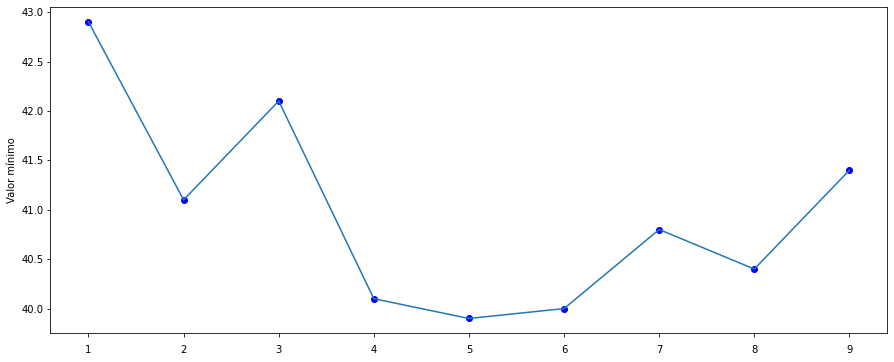

---------------------------------------------------------
Individuo 0 analizado en: 3.01 s
Individuo 1 analizado en: 2.94 s
Individuo 2 analizado en: 2.81 s


In [192]:
T_inicial = 50
Tf = 1
L = 0 #Cuando L=0, L se calcula dentro del temple simulado según la longitud de la orden de productos
parametros_temple = [T_inicial, Tf, L]

probabilidad_mutacion = 0.05
umbral_convergencia = 0.5
n_desv_estandar = 5 #como criterio se comparan los ultimas mejores puntuaciones
max_iteraciones = 100
k = 20 #si nos se mejora la puntuación luego de 10 iteraciones, se detiene
j = 0 #lleva el conteo de las iteraciones luego de conseguir la mejor puntuacion. Se reinicia al conseguir una mejor puntuacion

puntuaciones_historicas=[]  #almacena todas las puntuaciones

i=0 #Llevará registro del numero de iteracion

fig, ax = plt.subplots(figsize=(15, 6))
fig.set_facecolor('white') # Cambiar el fondo a blanco

mejor_individuo = None
mejor_puntuacion = 99999

flag = True
while flag:
    
    puntuaciones = puntuacion_poblacion(nodos_almacen,
                                        individuos,
                                        listas_ordenes,
                                        parametros_temple)
    
    puntuaciones_historicas.append(puntuaciones)

    #Guardo la mejor solucion y puntuaciones de todas
    if min(puntuaciones) < mejor_puntuacion:
        mejor_puntuacion = min(puntuaciones)
        indice = puntuaciones.index(mejor_puntuacion)
        mejor_individuo = individuos[indice]
        j=0 #reinicio el contador de iteraciones luego de conseguir una mejor puntuacion
    else:
        j+=1 #si no se consigue una mejor puntuación, aumenta en 1.
    

    actualizar_grafica(puntuaciones_historicas, ax, fig)
    
    #Establezco criterio de convergencia donde comparo las puntuación de la poblacion actual con la mejor puntuación. Si no ha sido superada en las proximas k iteraciones luego de conseguir la mejor, se detiene el algoritmo

    if j==k:
        flag = False
        print(f"Convergencia por no obtener mejor solucion luego de {k} iteraciones.")
        break

    #Establezco un criterio de convergencia donde se compara el mejor resultado  de la generacion actual con el de la generaciones anteriores
    # if i>n_desv_estandar: #para aegurar que estamos en la segunda iteracion
    #     if desviacion_estandar_n(puntuaciones_historicas,n_desv_estandar) < umbral_convergencia:
    #         flag = False
    #         print("Convergencia por diferencia entre mejores individuos")
    #         break
    #Tambien puedo detenerlo usando un límite de iteraciones
    if i==max_iteraciones:
        flag = False
        print("Se ha llegado al máximo de iteraciones")
        break
    
    #Crearé hijos hasta alcanzar el tamaño de la generacion actual
    hijos = []
    while len(hijos) < len(individuos):
        padre1, padre2 = ruleta_con_peso(individuos, puntuaciones)
        hijo1, hijo2 = cruzar_padres(padre1, padre2)

        #Cada hijo tendrá un 5% de probabilidad de mutar
        if random.random() < probabilidad_mutacion:
            hijo1 = mutacion(hijo1)
        if random.random() < probabilidad_mutacion:
            hijo2 = mutacion(hijo2)
        
        hijos.append(hijo1)
        hijos.append(hijo2)
    
    #Una vez creado todos los hijos, actualizo la lista de individuos y repito
    individuos = hijos
    
    #Aumento el contador de iteracioens
    i+=1

    print("---------------------------------------------------------")

#print(f"El mejor puntaje obtenido es {min(puntuaciones_historicas[-1])}")
print(f"El mejor puntaje obtenido es {mejor_puntuacion}")
print(f"Numero de iteraciones: {i+1}")

Obtengo el índice del menor valor en el vector de puntuaciones. Ese índice corresponde al individuo de mejor puntaje.

In [ ]:
#indice_del_menor = puntuaciones_historicas[-1].index(min(puntuaciones_historicas[-1]))

#mejor_individuo = individuos[indice_del_menor]

print(f"El mejor individuo es:\n{mejor_individuo}")
#print(f"Con puntuacion de: {min(puntuaciones_historicas[-1])}")
print(f"Con puntuacion de: {mejor_puntuacion}")

El mejor individuo es:
[15, 22, 35, 5, 40, 36, 27, 39, 44, 6, 30, 24, 8, 26, 38, 9, 12, 11, 37, 1, 13, 34, 21, 10, 19, 16, 18, 45, 7, 42, 2, 32, 46, 20, 31, 47, 23, 43, 17, 28, 25, 14, 41, 3, 29, 48, 4, 33]
Con puntuacion de: 42.1


Representación gráfica del almacen

In [ ]:
#Actualizo los números de producto
i=0
for nodo in nodos_almacen:
    nodo.numeroProducto = mejor_individuo[i]
    nodo.hacer_obstaculo()
    i+=1

#Limpio el resto de casillas
for fila in matriz:
    for nodo in fila:
        if nodo.es_abierta() or nodo.es_cerrada():
            nodo.resetear()

interfazGrafica(matriz)


Veo el camino para recoger alguna orden

In [ ]:
orden = listas_ordenes[2]

global INICIO
global FINAL
global CAMINO

CAMINO = []
OBJETIVOS_ALMACEN = []
for nodo in nodos_almacen:
    if nodo.numeroProducto in orden:
        nodo.hacer_objetivo_almacen()
        OBJETIVOS_ALMACEN.append(nodo)
    else:
        nodo.hacer_obstaculo()

solucion = recocidoSimulado(OBJETIVOS_ALMACEN, T_inicial=50, Tf=1, L=200)

CAMINO = A_estrella_lista(matriz, solucion)

#Limpio el tablero menos los espacios de almacén
for fila in matriz:
    for nodo in fila:
        if not nodo.es_espacio_almacen(): nodo.resetear()

#Vuelvo a establecer el inicio, el fin, los objetivos y establezco los nodos solución
INICIO.hacer_inicio()
FINAL.hacer_final()
for nodo in OBJETIVOS_ALMACEN: nodo.hacer_objetivo_almacen()
for nodo in CAMINO: nodo.hacer_solucion()

#Muestro dibujo
interfazGrafica(matriz)

TypeError: recocidoSimulado() got an unexpected keyword argument 'n'